<h1> Beer Review Analysis </h1>

- Which brewery produces the strongest beers by ABV%?
- If you had to pick 3 beers to recommend using only this data, which would you pick?
- Which of the factors (aroma, taste, appearance, palette) are most important in determining the overall quality of a beer?
- Lastly, if I typically enjoy a beer due to its aroma and appearance, which beer style should I try?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("beer_reviews.csv")
df['review_time']= pd.to_datetime(df['review_time'],unit="s")
df.head(10)

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,2009-02-16 20:57:03,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,2009-03-01 13:44:57,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,2009-03-01 14:10:04,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,2009-02-15 19:12:25,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,2010-12-30 18:53:26,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
5,1075,Caldera Brewing Company,2012-01-02 17:17:39,3.0,3.5,3.5,oline73,Herbed / Spiced Beer,3.0,3.5,Caldera Ginger Beer,4.7,52159
6,1075,Caldera Brewing Company,2011-10-19 02:25:15,3.5,3.5,3.5,Reidrover,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159
7,1075,Caldera Brewing Company,2011-05-24 22:26:58,3.0,2.5,3.5,alpinebryant,Herbed / Spiced Beer,2.0,3.5,Caldera Ginger Beer,4.7,52159
8,1075,Caldera Brewing Company,2010-11-22 19:35:03,4.0,3.0,3.5,LordAdmNelson,Herbed / Spiced Beer,3.5,4.0,Caldera Ginger Beer,4.7,52159
9,1075,Caldera Brewing Company,2010-09-28 00:15:24,4.5,3.5,5.0,augustgarage,Herbed / Spiced Beer,4.0,4.0,Caldera Ginger Beer,4.7,52159


In [2]:
len(df.columns)

13

In [3]:
print(df.nunique())
print("")
print("Duplicated rows: ", df.duplicated().sum())
print("Total rows: ", df.shape[0])
print("Total columns: ", df.shape[1])

print("\nMissing Values :", df.isnull().sum())

brewery_id               5840
brewery_name             5742
review_time           1577960
review_overall             10
review_aroma                9
review_appearance          10
review_profilename      33387
beer_style                104
review_palate               9
review_taste                9
beer_name               56857
beer_abv                  530
beer_beerid             66055
dtype: int64

Duplicated rows:  0
Total rows:  1586614
Total columns:  13

Missing Values : brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64


Initial impressions:


* Each row corresponds to a review of a beer
* There are more brewery_id than brewery_name, meaning there can be multiple id's for the same brewery
* Same for beer_beerid, seems like there can be multiple ids for the same beer_name
* There are more review_profilename than number of reviews, meaning there are multiple reviews per person
* The rating scale has up to 10 unique values with 0.5 intervals between 0.0-5.0
* Quite common for beer_abv to have a missing value
* Reviews are dated and span multiple years

In [4]:
# create unique review id for each row
beer_df = df.reset_index() ####### CONVERT INDEX TO COLUMN

In [5]:
print("Missing beer_abv values:", round(beer_df["beer_abv"].isnull().sum()/beer_df.shape[0]*100,2), "%")

Missing beer_abv values: 4.27 %


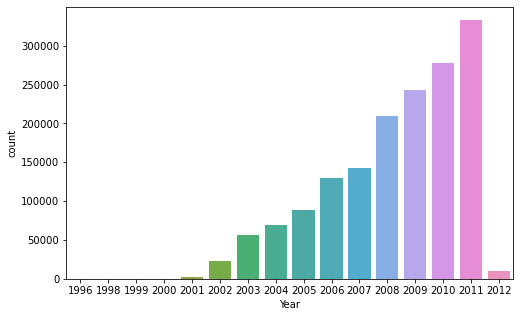

In [6]:
# check distribution of years

beer_df["Year"] = beer_df["review_time"].dt.year

plt.figure(figsize = (8,5))
year_dist = sns.countplot(x=beer_df["Year"])

The reviews were gathered over 1996-2012, with partially incomplete data for entire 2012. Older reviews should be less relevant when it comes to recommendations, as the beers might no longer be produced, or have been renamed, or consumer taste has changed.

Here the threshold will be set to filter for only the latest years of data (2006-2012)

In [213]:
# filter out old data
beer_df = beer_df[beer_df["Year"]>=2006]
beer_df.shape

beer_df.shape[0]/df.shape[0]

0.8479447427036444

In [8]:
# check why brewery_name and brewery_id doesn't line up

# create df of brewery_names and number of unique id counts
brewery_id_unique_counts_df = beer_df.groupby("brewery_name").agg({"brewery_id": pd.Series.nunique}).sort_values(by="brewery_id", ascending=False)
brewery_id_unique_counts_df = brewery_id_unique_counts_df.reset_index()
brewery_id_unique_counts_df.columns = ["brewery_name","nunique_of_brewery_id"]
brewery_id_unique_counts_df = brewery_id_unique_counts_df[brewery_id_unique_counts_df["nunique_of_brewery_id"]>1]

# create df of non-unique brewery_names and the brewery_id
brewery_id_non_unique_df = beer_df[beer_df["brewery_name"].isin(brewery_id_unique_counts_df["brewery_name"])][["brewery_name","brewery_id","review_time"]]
brewery_id_non_unique_df["rank"] = brewery_id_non_unique_df.groupby(["brewery_name","brewery_id"])["brewery_id"].rank(method="first", ascending=True)
brewery_id_non_unique_df[brewery_id_non_unique_df["rank"] == 1].sort_values(by="brewery_name")



,brewery_name,brewery_id,review_time,rank
544013,BJ's Restaurant & Brewery,3585,2007-08-19 21:38:00,1.0
536783,BJ's Restaurant & Brewery,3232,2008-03-01 04:11:23,1.0
989783,BJ's Restaurant & Brewery,9036,2006-12-03 11:37:34,1.0
394014,BJ's Restaurant & Brewery,2711,2010-03-26 02:12:40,1.0
676184,BJ's Restaurant & Brewhouse,27117,2011-11-09 20:50:13,1.0
...,...,...,...,...
203043,Two Rows Restaurant & Brewery,1115,2009-02-25 15:18:36,1.0
738806,Water Street Brewery,1910,2011-07-11 14:50:54,1.0
1313271,Water Street Brewery,12789,2010-12-13 08:47:42,1.0
383840,Whitstran Brewing Company,19868,2011-11-05 23:37:23,1.0


In [9]:
# check why beer_name and beer_beerid doesn't line up

# create df of beer_names and number of unique id counts
beer_id_unique_counts_df = beer_df.groupby(["brewery_name","beer_name"]).agg({"beer_beerid": pd.Series.nunique}).sort_values(by="beer_beerid", ascending=False)
beer_id_unique_counts_df = beer_id_unique_counts_df.reset_index()
beer_id_unique_counts_df.columns = ["brewery_name","beer_name","nunique_of_beer_id"]
beer_id_unique_counts_df = beer_id_unique_counts_df[beer_id_unique_counts_df["nunique_of_beer_id"]>1]

# create df of non-unique beer_names and the beer_beerid
beer_id_non_unique_df = beer_df[beer_df.set_index(["brewery_name","beer_name"]).index.isin(beer_id_unique_counts_df.set_index(["brewery_name","beer_name"]).index)][["brewery_name","beer_name","beer_beerid","review_time"]]
beer_id_non_unique_df["rank"] = beer_id_non_unique_df.groupby(["brewery_name","beer_name","beer_beerid"])["beer_beerid"].rank(method="first", ascending=True)
beer_id_non_unique_df[beer_id_non_unique_df["rank"] == 1].sort_values(by=["brewery_name","beer_name"])

,brewery_name,beer_name,beer_beerid,review_time,rank
394014,BJ's Restaurant & Brewery,Blonde,57096,2010-03-26 02:12:40,1.0
536991,BJ's Restaurant & Brewery,Blonde,41271,2009-01-20 05:01:38,1.0
394081,BJ's Restaurant & Brewery,Grand Cru,27766,2006-01-10 23:36:02,1.0
544426,BJ's Restaurant & Brewery,Grand Cru,40390,2009-01-02 04:23:50,1.0
394083,BJ's Restaurant & Brewery,Harvest Hefeweizen,57094,2010-03-26 02:00:09,1.0
...,...,...,...,...,...
1313327,Water Street Brewery,Pale Ale,64283,2010-12-10 22:44:55,1.0
739005,Water Street Brewery,Raspberry Weiss,8076,2009-10-23 22:51:34,1.0
1313320,Water Street Brewery,Raspberry Weiss,64368,2010-12-13 08:08:49,1.0
739055,Water Street Brewery,Water Street Amber,8074,2010-12-13 13:10:59,1.0


Brewery_names are mapped to multiple brewery_ids. On a high level, it appears that this is due to:
(1) time 
(2) Difference in nomenclature (e.g. Brewery vs Brewhouse) 


Likewise, beer_names are mapped to multiple beer_beerid because of the brewery naming their beers similarly. However, there are also cases where beer_names coming from the same brewery_name have multiple beer_beerid. For this analysis we can use beer_name in conjunction with brewery_name to identify beers.

<h3> Strongest beers by ABV </h3>

Which brewery produces the strongest beers by ABV%?


In [10]:
# create df of summary values for beer strength and number of beers per brewery
strong_beer_df_with_na_abv = beer_df.groupby("brewery_name").agg({'beer_name': pd.Series.nunique,
                                                             'beer_abv': ['min','max','median','mean']})

strong_beer_df_with_na_abv = strong_beer_df_with_na_abv.reset_index()
strong_beer_df_with_na_abv.columns = ["brewery_name","no_of_beers","beer_abv_min","beer_abv_max","beer_abv_median","beer_abv_mean"]

In [11]:
# create df of non-null ABV rows
beer_df_non_null_abv = beer_df[beer_df["beer_abv"].notna()]

# create df of summary values for number of beers per brewery
strong_beer_df = beer_df_non_null_abv.groupby("brewery_name").agg({'beer_name': pd.Series.nunique,
                                                                   'beer_abv': ['min','max','median','mean']})

strong_beer_df = strong_beer_df.reset_index()
strong_beer_df.columns = ["brewery_name","no_of_beers","beer_abv_min","beer_abv_max","beer_abv_median","beer_abv_mean"]

In [12]:
# number of beers per brewery (non NA ABV only)
print("Average number of beers per brewery (excluding null ABV%) ", round(np.average(strong_beer_df["no_of_beers"]),2))
print("Average number of beers per brewery: ", round(np.average(strong_beer_df_with_na_abv["no_of_beers"]),2))

Average number of beers per brewery (excluding null ABV%)  9.31
Average number of beers per brewery:  11.06


Average ABV%:  7.15


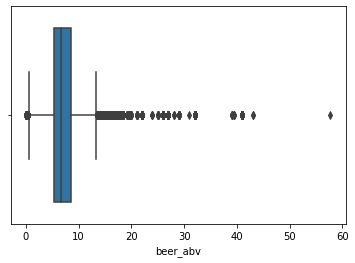

In [13]:
# review ABV% distribution
abv_ax = sns.boxplot(x=beer_df_non_null_abv["beer_abv"])

avg_abv = np.average(beer_df_non_null_abv["beer_abv"])
print("Average ABV%: ", round(avg_abv,2))

Most beers are around 5-9% ABV, but there are some outliers with ~60% and 0%.

In [200]:
threshold_strong_beer_min_beer = 3

strongest_beers = strong_beer_df[strong_beer_df["no_of_beers"]> threshold_strong_beer_min_beer]

print("Strongest 5 beers by mean: ")
strongest_beers.nlargest(5,"beer_abv_mean")

Strongest 5 beers by mean: 


,brewery_name,no_of_beers,beer_abv_min,beer_abv_max,beer_abv_median,beer_abv_mean
3891,Schorschbräu,10,4.90,57.7,13.0,20.563571
712,Brasserie Grain d' Orge (Brasserie Jeanne d'Ar...,10,4.50,13.0,13.0,12.241081
923,Brauerei Schloss Eggenberg,14,4.80,14.0,14.0,11.845332
2635,Kuhnhenn Brewing Company,117,3.25,18.0,13.5,11.837981
701,Brasserie Dubuisson Frères sprl,14,7.00,13.0,12.0,11.452756


In [203]:
avg_abv = np.average(strong_beer_df[strong_beer_df["no_of_beers"]> threshold_strong_beer_min_beer]["beer_abv_mean"])
print(avg_abv)

6.106323847073894


Evaluating the brewery's overall beer offerings, these three has the highest mean ABV% - their beer offerings tend to be stronger overall. While the industry average ABV is around 6%, these three breweries produce beers that have on average 2-3x higher ABV%.

It's also interesting to look at the strongest beer and who produces them:

In [14]:
# create df of summary values for beer strength 
strongest_beer_df = beer_df_non_null_abv.groupby(["brewery_name","beer_name"]).agg({'no''beer_abv': ["max","mean"]})
strongest_beer_df = strongest_beer_df.reset_index()
strongest_beer_df.columns = ["brewery_name","beer_name","beer_abv_max","beer_abv_mean"]
strongest_beer_df["rank"] = strongest_beer_df.groupby(["brewery_name"])["beer_abv_max"].rank(ascending = False, method="first")

print("Brewery with strongest beer: ")
strongest_beer_df[strongest_beer_df["rank"] == 1].sort_values(by="beer_abv_max", ascending = False).head(5)

Brewery with strongest beer: 


,brewery_name,beer_name,beer_abv_max,beer_abv_mean,rank
35406,Schorschbräu,Schorschbräu Schorschbock 57%,57.7,57.7,1.0
7641,BrewDog,Sink The Bismarck!,41.0,41.0,1.0
13409,De Struise Brouwers,Black Damnation VI - Messy,39.0,39.0,1.0
19373,Hair of the Dog Brewing Company / Brewery and ...,Dave,29.0,29.0,1.0
5296,Boston Beer Company (Samuel Adams),Samuel Adams Utopias,27.0,27.0,1.0


<h3> Three Beer Recommendations </h3>

If you had to pick 3 beers to recommend using only this data, which would you pick?


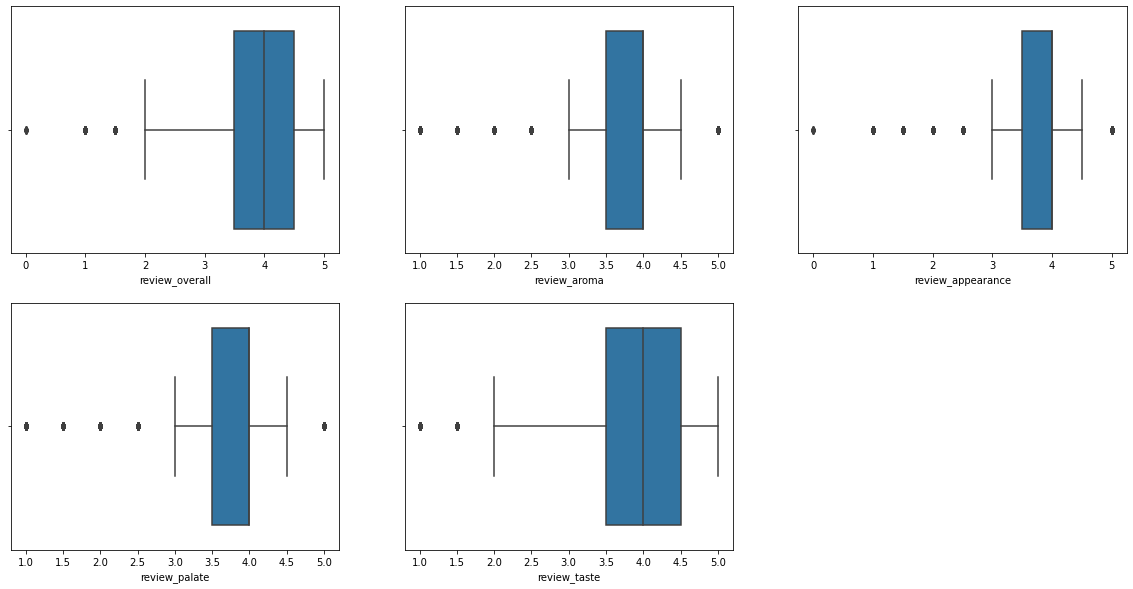

In [17]:
review_cols = ["review_overall","review_aroma","review_appearance","review_palate","review_taste"]

# review rating distribution

fig1 = plt.figure(figsize=(20,10))
position = 1

for r in review_cols:
    plt.subplot(2,len(review_cols)-2,position)
    sns.boxplot(x=df[r])
    
    position+=1

In [18]:
# create df of summary values for number of beers produced, number of reviews, and review ratings for each beer and overall brewery
brewery_rating_df = beer_df.groupby("brewery_name").agg({'beer_name': pd.Series.nunique,
                                                    'index': pd.Series.nunique,
                                                    'review_overall': "mean",
                                                    'review_aroma': "mean",
                                                    'review_appearance': "mean"
                                                    })
                                                    
brewery_rating_df.columns = ["number_of_beers","number_of_reviews","review_overall_mean","review_aroma_mean","review_appearance_mean"]


In [79]:
avg_beer_per_brewery = np.average(brewery_rating_df["number_of_beers"])
avg_review_per_brewery = np.average(brewery_rating_df["number_of_reviews"])
                                    
print("Average number of beers per brewery: ", round(avg_beer_per_brewery,2))
print("Average number of reviews per brewery: ", round(avg_review_per_brewery,2))

brewery_rating_df.head(10)

Average number of beers per brewery:  11.06
Average number of reviews per brewery:  256.6


,number_of_beers,number_of_reviews,review_overall_mean,review_aroma_mean,review_appearance_mean
brewery_name,,,,,
't Hofbrouwerijke,7,37,3.702703,3.783784,3.851351
(512) Brewing Company,14,304,4.065789,4.001645,4.057566
10 Barrel Brewing Co.,17,84,3.732143,3.571429,3.815476
1516 Brewing Company,17,32,4.171875,3.921875,4.234375
16 Mile Brewing Company,6,92,3.570652,3.402174,3.766304
1648 Brewing Company Ltd,1,1,3.500000,4.000000,3.500000
1702 / The Address Brewing Co.,1,1,4.000000,4.500000,4.000000
192 Brewing Company,3,3,1.833333,2.833333,3.166667
2 Brothers Brewery,9,51,3.686275,3.617647,3.627451


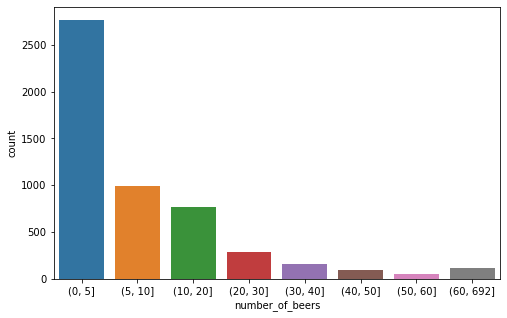

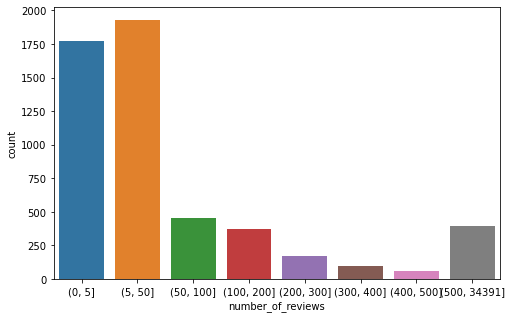

In [76]:
plt.figure(figsize = (8,5))
no_of_beers_dist = sns.countplot(x=pd.cut(brewery_rating_df["number_of_beers"], bins=[0,5,10,20,30,40,50,60,np.max(brewery_rating_df["number_of_beers"])]))

plt.figure(figsize = (8,5))
no_of_beers_dist = sns.countplot(x=pd.cut(brewery_rating_df["number_of_reviews"], bins=[0,5,50,100,200,300,400,500,np.max(brewery_rating_df["number_of_reviews"])]))


In [20]:
# create df of summary values for number of beers produced, number of reviews, and review ratings for each beer and overall brewery
beer_rating_df = beer_df.groupby(["brewery_name","beer_name"]).agg({'index': pd.Series.nunique,
                                                    'review_overall': "mean",
                                                    'review_aroma': "mean",
                                                    'review_appearance': "mean"})
          
beer_rating_df = beer_rating_df.reset_index()
beer_rating_df.columns = ["brewery_name","beer_name","number_of_reviews","review_overall_mean","review_aroma_mean","review_appearance_mean"]

beer_rating_df.head(5)

,brewery_name,beer_name,number_of_reviews,review_overall_mean,review_aroma_mean,review_appearance_mean
0,'t Hofbrouwerijke,Blondelle,1,4.000000,4.500000,3.500000
1,'t Hofbrouwerijke,Bosprotter,9,3.722222,3.833333,3.666667
2,'t Hofbrouwerijke,Hof Korvatunturi,2,3.750000,4.000000,3.750000
3,'t Hofbrouwerijke,Hofblues,16,3.812500,3.812500,4.000000
4,'t Hofbrouwerijke,Hofdraak,7,3.357143,3.428571,3.714286


In [80]:
avg_rating_per_beer = np.average(beer_rating_df["number_of_reviews"])
print("Average number of reviews per beer: ", round(avg_rating_per_beer,2))      

Average number of reviews per beer:  23.21


In [82]:
# create view of brewery ratings and beer ratings
beer_brewery_ratings_df = pd.merge(left=beer_rating_df,
                                   right=brewery_rating_df,
                                   how="outer",
                                   on="brewery_name",
                                   suffixes=("_beer","_brewery"))

In [210]:
# simple scoring metric that evaluates overall beer reviews and brewery reviews
# no weighting
beer_brewery_ratings_df["overall_score_mean"] = beer_brewery_ratings_df["review_overall_mean_brewery"] + beer_brewery_ratings_df["review_overall_mean_beer"]

# filtering system to only show breweries and beerswith minimum number of reviews
# min_brewery_review_threshold = 100
min_beer_review_threshold = 100
# filter_condition_1 = beer_brewery_ratings_df["number_of_reviews_brewery"] > min_brewery_review_threshold
filter_condition_2 = beer_brewery_ratings_df["number_of_reviews_beer"] > min_beer_review_threshold

beer_rec_1 = beer_brewery_ratings_df[filter_condition_2]
beer_rec_1.nlargest(3,"overall_score_mean")

,brewery_name,beer_name,number_of_reviews_beer,review_overall_mean_beer,review_aroma_mean_beer,review_appearance_mean_beer,number_of_beers,number_of_reviews_brewery,review_overall_mean_brewery,review_aroma_mean_brewery,review_appearance_mean_brewery,overall_score_mean
50646,The Alchemist,Heady Topper,458,4.629913,4.661572,4.159389,3,516,4.585271,4.609496,4.168605,9.215184
11751,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,Trappist Westvleteren 12,1063,4.634995,4.584196,4.446378,5,1954,4.555015,4.461361,4.394831,9.190011
11752,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,Trappist Westvleteren 8,550,4.512727,4.402727,4.397273,5,1954,4.555015,4.461361,4.394831,9.067743


In [208]:
np.average(beer_rec_1["overall_score_mean"])

7.630535349961845

Based on overall brewery popularity and the specific beer popularity (mean rating), these three beers are recommended.

<h3>Best beer for aroma and appearance </h3>

If I typically enjoy a beer due to its aroma and appearance, which beer style should I try?

We assume that only aroma and appearance matters - no weight will be given to the other review variables.

In [89]:
# create df of summary values for number of beers produced, number of reviews, and review ratings for each beer and overall brewery
beer_style_rating_df = beer_df.groupby("beer_style").agg({'beer_name': pd.Series.nunique,
                                                    'index': pd.Series.nunique,
                                                    'review_overall': "mean",
                                                    'review_aroma': "mean",
                                                    'review_appearance': "mean"
                                                    })

beer_style_rating_df = beer_style_rating_df.reset_index()
beer_style_rating_df.columns = ["beer_style","number_of_beers","number_of_reviews","review_overall_mean","review_aroma_mean","review_appearance_mean"]

12936.163461538461
504.4326923076923


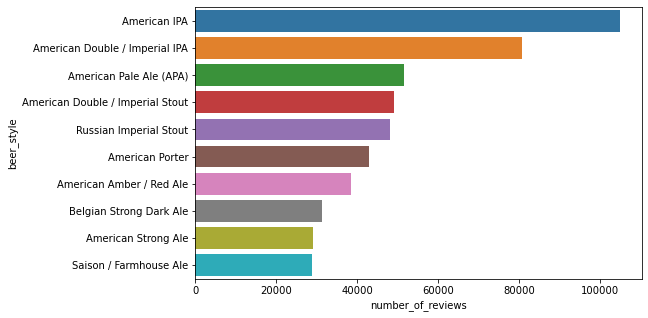

In [111]:
avg_review_per_beer_style = np.average(beer_style_rating_df["number_of_reviews"])
avg_beer_per_beer_style = np.average(beer_style_rating_df["number_of_beers"])

print(avg_review_per_beer_style)
print(avg_beer_per_beer_style)

plt.figure(figsize = (8,5))
no_of_beers_dist = sns.barplot(x=beer_style_rating_df.sort_values(by="number_of_reviews", ascending=False).head(10)["number_of_reviews"], 
                               y=beer_style_rating_df.sort_values(by="number_of_reviews", ascending=False).head(10)["beer_style"])

In [211]:
# simple scoring metric that evaluates aroma and appearance ratings 
beer_style_rating_df["aroma_appearance_score"] = beer_style_rating_df[["review_aroma_mean","review_appearance_mean"]].sum(axis=1)

# metric based on the aroma_appearance_score multiplied by how much the aroma and appearance overindex compared to average
beer_style_rating_df["aroma_appearance_overall_score"] = beer_style_rating_df["aroma_appearance_score"]/(beer_style_rating_df["review_overall_mean"]*2)*beer_style_rating_df["aroma_appearance_score"]

# normalize score compared to the rest of dataset
beer_style_rating_df["aroma_appearance_overall_score_norm"] = beer_style_rating_df["aroma_appearance_overall_score"]/np.max(beer_style_rating_df["aroma_appearance_overall_score"])

# filtering mechanism for validity
min_beer_threshold = 100
min_beer_review_beerstyle_threshold = 100

rec2_filter_condition_1 = beer_style_rating_df["number_of_reviews"] >= min_beerstyle_review_threshold
rec2_filter_condition_2 = beer_style_rating_df["number_of_beers"] >= min_beer_threshold

beer_rec_2 = beer_style_rating_df[rec2_filter_condition_1 & rec2_filter_condition_2]
beer_rec_2.nlargest(5,"aroma_appearance_overall_score_norm")


# beer_style_rating_df


,beer_style,number_of_beers,number_of_reviews,review_overall_mean,review_aroma_mean,review_appearance_mean,aroma_appearance_score,aroma_appearance_overall_score,aroma_appearance_overall_score_norm
11,American Double / Imperial Stout,841,49091,4.028060,4.158736,4.159734,8.318470,8.589363,1.000000
89,Russian Imperial Stout,702,48149,4.016709,4.065443,4.199610,8.265052,8.503366,0.989988
9,American Double / Imperial IPA,1369,80845,3.993234,4.089999,4.074927,8.164927,8.347373,0.971827
86,Quadrupel (Quad),186,15779,4.060397,4.116357,4.100703,8.217061,8.314469,0.967996
4,American Barleywine,714,22825,3.883352,4.002015,4.026857,8.028872,8.299890,0.966299


In [212]:
np.average(beer_rec_2["aroma_appearance_overall_score"])

7.329394972574671

The American Double/ Imperial Stout is recommended as it has the highest aroma and appearance satisfaction as a component to overall satisfaction.

<h3> Factors determining overall quality </h3>

Which of the factors (aroma, taste, appearance, palette) are most important in determining the overall quality of a beer?


Text(0.5, 1.0, 'All data')

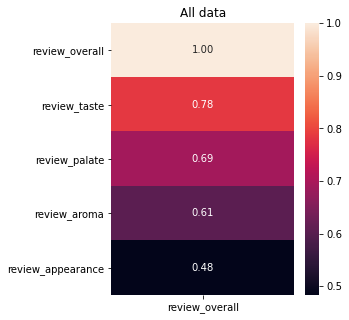

In [115]:
fig2 = plt.figure(figsize=(9,5))
    
# using all the data
plt.subplot(1,2,1)
sns.heatmap(beer_df[review_cols].corr()[["review_overall"]].sort_values(by="review_overall",ascending=False), annot=True, fmt=".2f")
plt.title("All data")


Taste is most highly correlated to overall reviews.

In [216]:
beer_reviews_cor_df = beer_df

def review_bucket(review_score):
    if review_score <= 2.0:
        return 'Low'
    elif review_score <=4.0:
        return 'Med'
    elif review_score >4.0:
        return 'High'
    else:
        return 'No score'
    
review_bucket_col_list = []

for r in review_cols:
    col_name = str(r) + '_bucket'
    beer_reviews_cor_df[col_name] = beer_reviews_cor_df[r].apply(lambda x: review_bucket(x))
    review_bucket_col_list.append(col_name)

In [217]:
review_bucket = beer_reviews_cor_df[beer_reviews_cor_df["review_overall_bucket"]=="High"][review_bucket_col_list]

In [218]:
bucket_reviews_summary = pd.DataFrame(columns=["Review_type","% high"])

for r in review_cols[1:]:
    col = r + "_bucket"
    bucket_reviews_summary = bucket_reviews_summary.append({"Review_type": r,
                                                            "% high": len(review_bucket[review_bucket[col]=="High"])/len(review_bucket[col])},
                                                           ignore_index=True)
    
bucket_reviews_summary


,Review_type,% high
0,review_aroma,0.445793
1,review_appearance,0.418143
2,review_palate,0.477613
3,review_taste,0.633059


63.3% of reviewers who give a high taste rating also give a high overall rating.